---

# <center> Spectral Clustering
### <center> Realized By: Eya Ghamgui
<center> eya.ghamgui@telecom-paris.fr
<center> February 10, 2022
    
--- 

In this exercise, you will implement spectral clustering and try it on diffrent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


<font color = 'red'>**REMARK:**

<font color = 'red'> In order to restore the notebook results, please download the functions from this link. Actually, I changed a bit the plotting functions in order to construct subplots in the notebook. I added the axes entery to specify the location of the plot. In addition, I included the image used for question 3.3 in this same link.

https://drive.google.com/drive/folders/1UHUqK8pyic6Tm4KJaZELVy5bc8soJksr?usp=sharing

## Setup

In [1]:
import os
import cv2
import scipy
import numpy as np
from skimage import io
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image, ImageEnhance
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clustering_result, plot_the_bend, plot_edges_and_points
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree

import warnings
warnings.filterwarnings("ignore")

## Generating the data

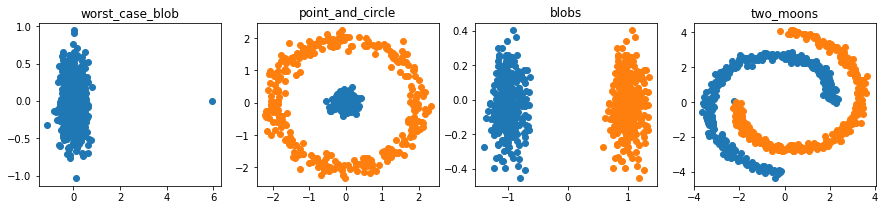

In [2]:
fig, ax = plt.subplots(1,4, figsize=(15, 3))
modes = [worst_case_blob, point_and_circle, blobs,two_moons]

for i in range(len(modes)): 
    X, Y = modes[i](num_samples=600)
    plot_clusters(X, Y, fignum=str(modes[i]), ax = ax[i], title = str(modes[i].__name__))

## Building similarity graph

In [3]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0, method='or'):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
    similarities = np.zeros((n, n))
    for i in range(n): 
        for j in range(n): 
            if i!=j : 
                similarities[i,j] = np.exp(-np.linalg.norm(X[i]-X[j])**2/(2*var))
        
    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        mask = (similarities >= eps).astype(int)
        W = np.multiply(mask , similarities)

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, 
        and 0 for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        # The 'or' option
        if method == 'or' : 
            for i in range(n):
                k_nn_i = np.argsort( -similarities[i,:])[:k] 
                for j in k_nn_i: 
                    W[i,j] = similarities[i,j]
                    W[j,i] = similarities[i,j]
                
        # The 'and' option 
        if method == 'and' : 
            for i in range(n):
                k_nn_i = np.argsort(-similarities[i,:])[:k] 
                for j in k_nn_i : 
                    k_nn_j = np.argsort(-similarities[j,:])[:k] 
                    if i in k_nn_j :
                        W[i,j] = similarities[i,j]
                        W[j,i] = similarities[i,j]  
                        
    return W

- Example of k-NN graph with the "AND" option:


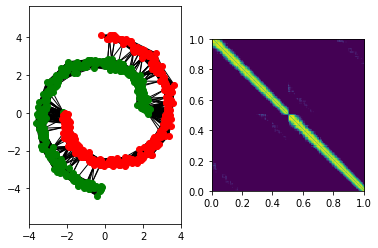

- Example of k-NN graph with the "OR" option:


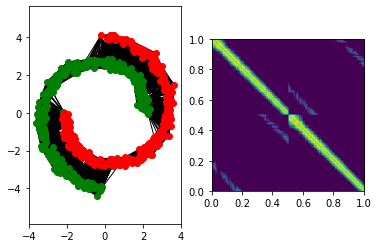

- Example of epsilon-graph:


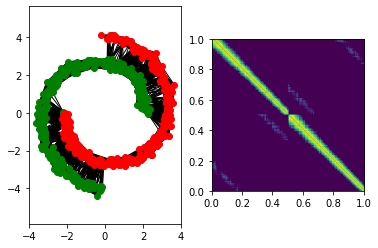

In [4]:
# Examples

print('- Example of k-NN graph with the "AND" option:')
W = build_similarity_graph(X, k=50, method='and')
plot_graph_matrix(X, Y, W)  

print('- Example of k-NN graph with the "OR" option:')
W = build_similarity_graph(X, k=50, method='or')
plot_graph_matrix(X, Y, W) 

print('- Example of epsilon-graph:')
W = build_similarity_graph(X, eps= 0.5)
plot_graph_matrix(X, Y, W)  

**Interpretation:** 

> For the $k-nn$ graph, we notice that the "OR" option, which is based on ignoring the directions of the graph, gives a more connected graph. Moreover, the "AND" option preserves edges in the graph only in the case when this edge is connected in both directions. This leads to fewer edges in the second graph compared to the first one. 

## Computing the Laplacian

In [5]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    n = W.shape[0]
    L = np.zeros((n,n))
    D = np.diag(np.sum(W , axis=1))
    
    if laplacian_normalization == 'unn' : 
        L = D - W 

    if laplacian_normalization == 'sym' :
        L =  np.eye(n) - np.dot(np.dot(np.sqrt(np.linalg.pinv(D)),W),np.sqrt(np.linalg.pinv(D)))         
          
    if laplacian_normalization == 'rw' : 
        L = np.eye(n) - np.dot(np.linalg.pinv(D),W)
        
    return L

## Clustering

In [6]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2, show=False):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)

    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """    
    
    eigenvalues, eigenvectors = scipy.linalg.eig(L)
    idx = eigenvalues.argsort()  
    eigenvalues = eigenvalues[idx].real
    U = eigenvectors[:,idx].real
    E = np.diag(eigenvalues)
    
    """
    # compute the clustering assignment from the eigenvectors        
    # Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    
    if chosen_eig_indices == None :
        
        eigenvalues /= np.sum(eigenvalues)
        cum_values = np.cumsum(eigenvalues)
        ind = np.sum(cum_values < 1e-5)
        if ind == 1 :
            ind += 1
    
        chosen_eig_indices = np.arange(1,ind)
        
        if show:
            plt.plot(eigenvalues[:20] ,marker = 'o')
            plt.title("First 20 eigenvalues")
            plt.show()
            
            print('Chosen Eigenvectors are:')
            if len(chosen_eig_indices)>1 : 
                fig , ax = plt.subplots(1,len(chosen_eig_indices),figsize=(15,4))
                for i in range(len(chosen_eig_indices)) : 
                    ax[i].plot(U[:,chosen_eig_indices[i]])
                    ax[i].set_title('Eigenvector '+ str(chosen_eig_indices[i]))
                plt.show()
            
            else: 
                plt.plot(U[:,chosen_eig_indices])
                plt.title('Eigenvector '+ str(chosen_eig_indices[0]))
                plt.show()
   
    U = U[:, chosen_eig_indices]
    Y = KMeans(num_classes).fit_predict(U)
    
    return Y

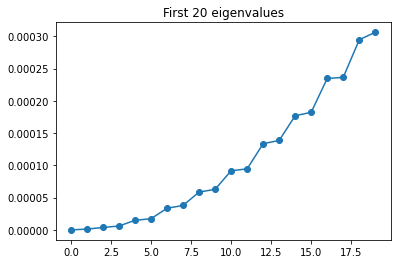

Chosen Eigenvectors are:


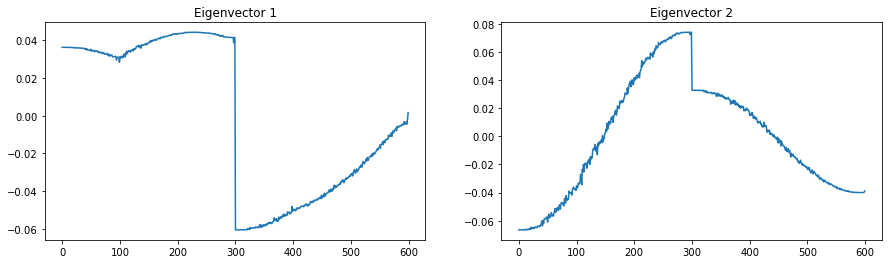

  Spectral clustering results, comparing to KMeans:


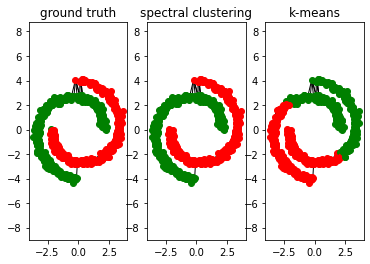

In [7]:
num_classes = 2
W = build_similarity_graph(X, k=20, method = 'or')
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes, show = True)

print('  Spectral clustering results, comparing to KMeans:')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [8]:
def parameter_sensitivity():
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization_list = ['unn','rw','sym']
    chosen_eig_indices = None
    
    """
    Choose candidate parameters
    """
    # Generate data
    X, Y = two_moons(num_samples, 1, 0.02)
    num_classes = len(np.unique(Y))
        
    print('- KNN graph case: ')
    parameter_type = 'k'
    parameter_candidate = [5,10,11,12,13,14,15,16,17,20,25,30]  # the number of neighbours for the graph (if 'k')
    plt.figure()
    
    for laplacian_normalization in laplacian_normalization_list :
        
        parameter_performance = []
        for parameter in parameter_candidate:
            parameter_wrap = {parameter_type: parameter}
            W = build_similarity_graph(X, **parameter_wrap)
            L = build_laplacian(W, laplacian_normalization)
            Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)
            parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

        plt.plot(parameter_candidate, parameter_performance , label = laplacian_normalization)
        plt.title(f'parameter sensitivity ({parameter_type})')
        
    plt.legend()
    plt.show()

    print('- Epsilon graph case: ')
    parameter_type = 'eps'
    parameter_candidate = np.arange(0,1,0.04) # the epsilon threshold (if 'eps')
    plt.figure()
    
    for laplacian_normalization in laplacian_normalization_list :
        
        parameter_performance = []
        for parameter in parameter_candidate:
            parameter_wrap = {parameter_type: parameter}
            W = build_similarity_graph(X, **parameter_wrap)
            L = build_laplacian(W, laplacian_normalization)
            Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)
            parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

        plt.plot(parameter_candidate, parameter_performance , label = laplacian_normalization)
        plt.title(f'parameter sensitivity ({parameter_type})')
        
    plt.legend()
    plt.show()

## Image segmentation

In [9]:
def image_segmentation(input_img, k=20, laplacian_normalization='unn', num_classes=5, chosen_eig_indices=None, show=False):
    
    """
    TO BE COMPLETED
    Function to perform image segmentation.
    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    
    # Read the image 
    filename = os.path.join('data', input_img)
    X = io.imread(filename)  
    
    # Change the scale (standardize the image)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
    number of segments you want to split the image into          
    """
    
    # Spectral clustering 
    W = build_similarity_graph(Xr, var=1.0, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes, show = show)
    Y_rec = Y_rec.reshape(im_side, im_side)
    
    # Show results 
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(X)
    plt.subplot(1, 2, 2)
    plt.imshow(Y_rec)      
    plt.show()

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

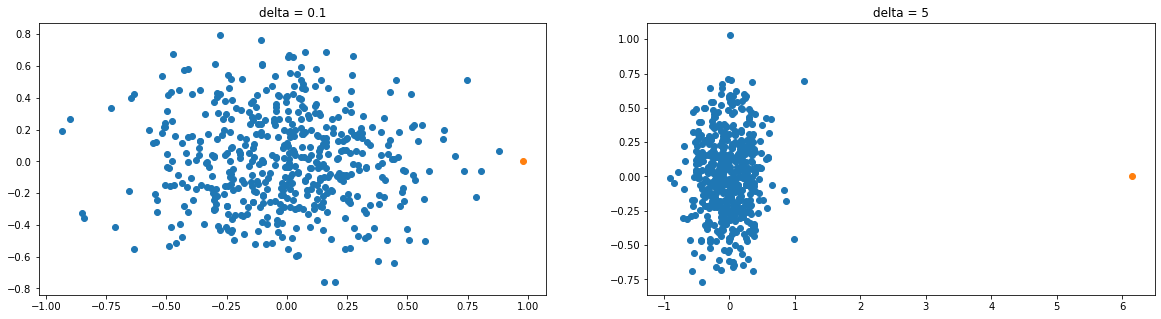

In [10]:
# Choose random values for delta 
delta = [0.1 , 5]
fig, ax = plt.subplots(1,2,figsize=(20,5))

for i in range(len(delta)) : 
    
    # Generate data 
    X , Y = worst_case_blob(500, delta[i])
    
    # Change this value to add color to plot
    Y[-1] = 1 
    
    # Plot the graph
    plot_clusters(X,Y, ax = ax[i], title ='delta = '+ str(delta[i]))
    
plt.show()

**Answer:** 

> The purpose of the optional parameter of the worst_case_blob function is to add a distance between a blob of points and a point from the blob. If the distance is small, as shown in the left plot, we can say that we cannot distinguish the samples of the blob and the point. If this distance is larger, then we can separate this point from the blob. In the second case, this point seems to be an outlier compared to the sample of points concentrated in the blob. 

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

- For delta = 0.1
    Epsilon =  0.9639583845888557
    Number of edges of fully connected graph :  124750
    Number of edges of epsilon graph :  23891
    Percentage of removing edges :  80.849 %


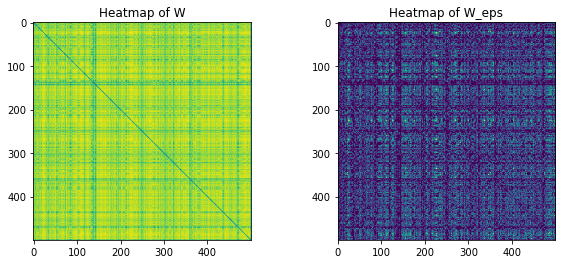

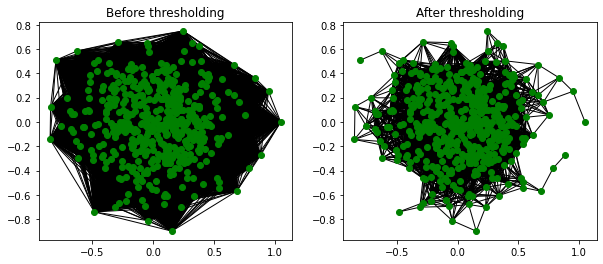

- For delta = 0.5
    Epsilon =  0.7758434999507408
    Number of edges of fully connected graph :  124750
    Number of edges of epsilon graph :  91262
    Percentage of removing edges :  26.844 %


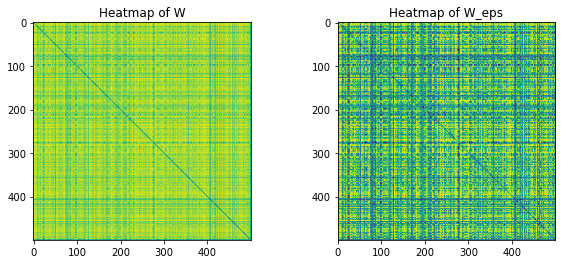

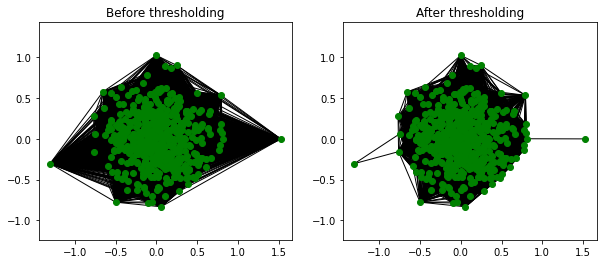

- For delta = 2.5
    Epsilon =  0.038753923659248825
    Number of edges of fully connected graph :  124750
    Number of edges of epsilon graph :  124252
    Percentage of removing edges :  0.399 %


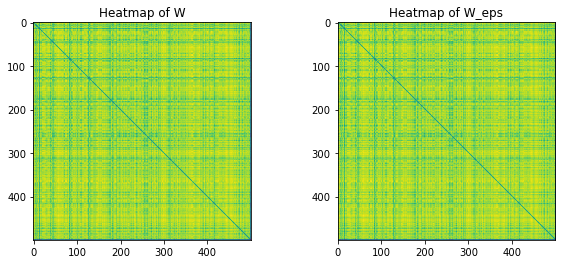

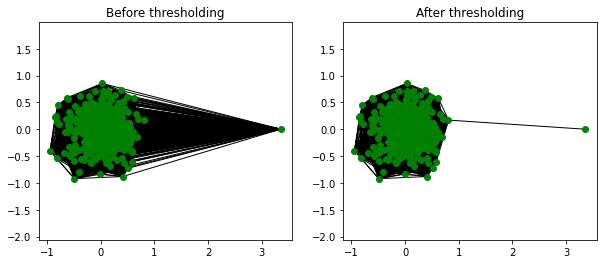

In [11]:
delta = [0.1,0.5,2.5]

for d in delta: 
    
    print('- For delta = '+str(d))
    n = 500
    X , Y = worst_case_blob(n, d)
    
    # Compute weights for fully connected graph 
    W = build_similarity_graph(X)
    Tr = W * min_span_tree(-W)
    
    # Determine epsilon and the corresponding epsilon-graph
    eps = np.min(Tr[np.nonzero(Tr)]) 
    print('    Epsilon = ',eps)
    W_eps = build_similarity_graph(X, eps = eps)
    
    # Compute edges 
    n_edg = np.sum(W>0)//2
    n_edg_eps = np.sum(W_eps>0)//2
    print('    Number of edges of fully connected graph : ', n_edg) 
    print('    Number of edges of epsilon graph : ', n_edg_eps)
    print('    Percentage of removing edges : ' , np.round(100*(n_edg - n_edg_eps)/n_edg , 3), '%')
    
    # Plotting matricies 
    fig, ax = plt.subplots(1,2 , figsize=(10,4))
    ax[0].imshow(W)
    ax[0].set_title('Heatmap of W')
    ax[1].imshow(W_eps)
    ax[1].set_title('Heatmap of W_eps')
    plt.show()   
    
    fig, ax = plt.subplots(1,2 , figsize=(10,4))
    plot_edges_and_points(X, Y, W, ax[0], title='Before thresholding')
    plot_edges_and_points(X, Y, W_eps, ax[1], title='After thresholding')
    plt.show()

**Answer:** 

> - A minimum spanning tree is a graph consisting of the subset of edges that connect all connected nodes together, while minimizing the total sum of weights on the edges. The purpose of this question is to select a value of $\epsilon$ while keeping the graph connected with edges having the highest similarities. To do so, we built the minimum spanning tree on ($-W$) in order to keep the lowest weights that correspond to the highest similarities. After obtaining the aforementioned graph, we selected $\epsilon$ as the smallest non-zero weight of this graph. Thus, thresholding $W$ matrix according to this value will ensure that the graph remains connected.
<br><br>
> - We applied the previous method using worst_case_blob while varying the delta values. For small delta values, this method is efficient, we can highly reduce the size of the graph (around $80 \%$ of the edges are reduced with $~detla = 0.1$) also the adjacency matrix becomes sparse, which helps reducing memory and computational time for clustering task. However, for higher values of delta, this method does not help the clustering. In fact, only $0.4 \%$ of edges are reduced with $~delta = 2.5$ and $26.8 \%$ with $~delta = 0.5$. Since the point and the blob are distant from each other, the edges that connect these nodes have a very low similarity coefficient and, therefore, $ \epsilon$ becomes very small. Thus, only few edges will be removed and the graph will remain almost fully-connected. 
<br><br> 
$\Longrightarrow$ We can conclude that this method is not robust to outliers. Thus, when our data is noisy and contains too much noise, this method would be a bad approach to use.

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

- Separate Blobs Example: 


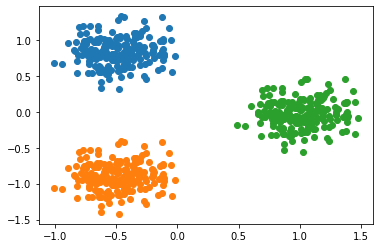

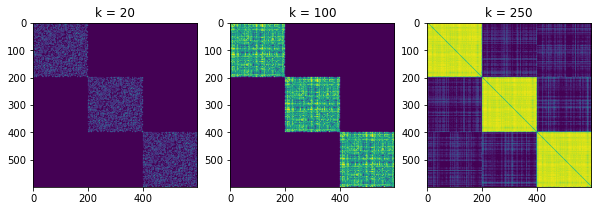

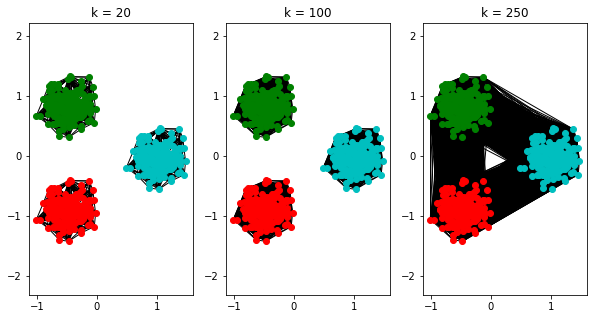

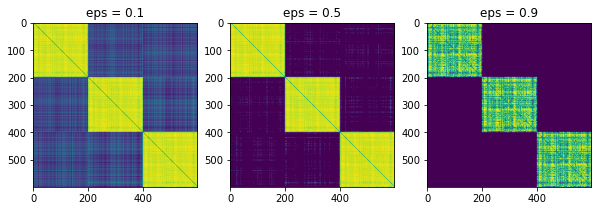

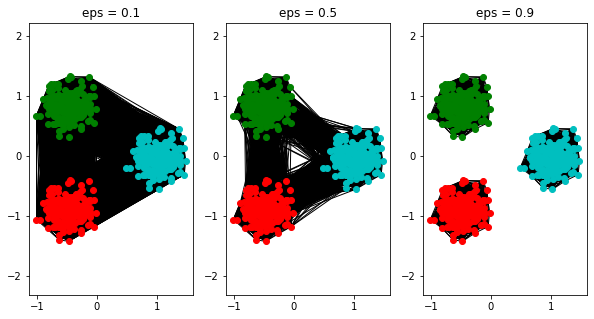

- Worst_case_blob Example with delta = 2.5: 


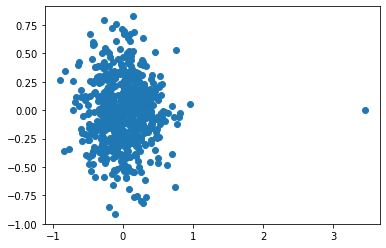

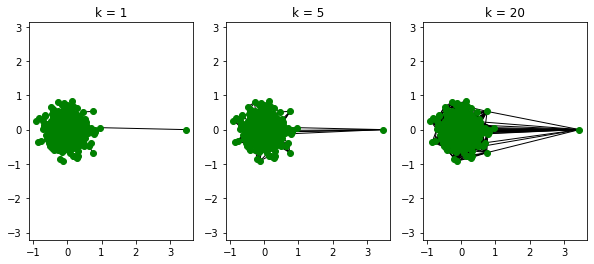

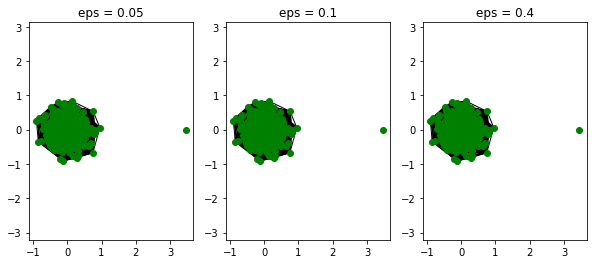

- two_moons Example: 


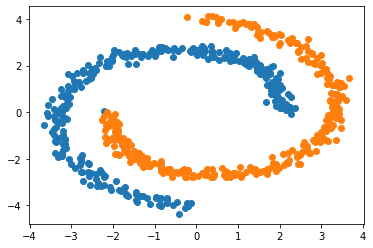

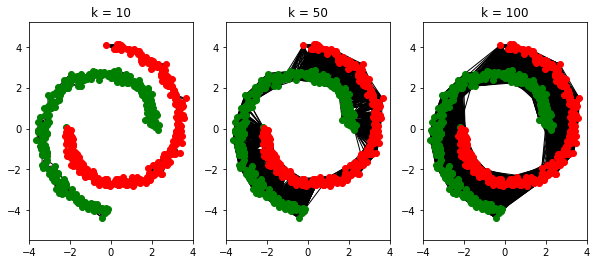

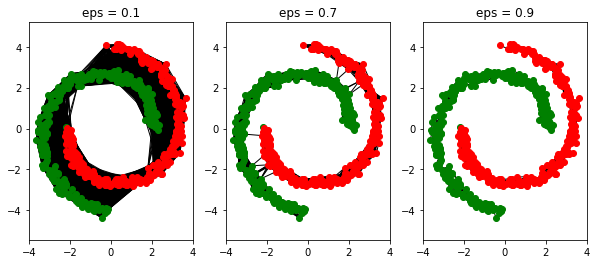

In [12]:
print("- Separate Blobs Example: ")

X , Y = blobs(600, n_blobs=3, blob_var=0.2)
plot_clusters(X,Y)
plt.show()
    
k_list = [20 , 100 , 250]
fig, ax = plt.subplots(1,3,figsize=(10,5))
fig1, ax1 = plt.subplots(1,3,figsize=(10,5))

for i in range(len(k_list)):
    W = build_similarity_graph(X, k = k_list[i])
    ax[i].imshow(W)
    ax[i].set_title('k = '+ str(k_list[i]))
    plot_edges_and_points(X, Y, W ,ax1[i], title='k = '+str(k_list[i]))

plt.show()  
    
eps_list = [0.1 , 0.5 , 0.9]
fig, ax = plt.subplots(1,3,figsize=(10,5))
fig1, ax1 = plt.subplots(1,3,figsize=(10,5))

for i in range(len(eps_list)):
    W = build_similarity_graph(X, eps = eps_list[i])
    ax[i].imshow(W)
    ax[i].set_title('eps = '+ str(eps_list[i]))
    plot_edges_and_points(X, Y, W, ax1[i] , title='eps = '+str(eps_list[i]))
plt.show()  

#####################################################
#####################################################

print("- Worst_case_blob Example with delta = 2.5: ")

X , Y = worst_case_blob(600, delta = 2.5)
plot_clusters(X,Y)
plt.show()
    
fig, ax = plt.subplots(1,3,figsize=(10,4))
k_list = [1 , 5 , 20]

for i in range(len(k_list)):
    W = build_similarity_graph(X, k = k_list[i])
    plot_edges_and_points(X, Y, W ,ax[i], title='k = '+str(k_list[i]))
plt.show()

fig, ax = plt.subplots(1,3,figsize=(10,4)) 
eps_list = [0.05 , 0.1 , 0.4]

for i in range(len(eps_list)):
    W = build_similarity_graph(X, eps = eps_list[i])  
    plot_edges_and_points(X, Y, W, ax[i] , title='eps = '+str(eps_list[i]))
plt.show()

#####################################################
#####################################################

print("- two_moons Example: ")

X , Y = two_moons(600)
plot_clusters(X,Y)
plt.show()
    
fig, ax = plt.subplots(1,3,figsize=(10,4))
k_list = [10,50,100]

for i in range(len(k_list)):
    W = build_similarity_graph(X, k = k_list[i])
    plot_edges_and_points(X, Y, W ,ax[i], title='k = '+str(k_list[i]))
plt.show()

fig, ax = plt.subplots(1,3,figsize=(10,4)) 
eps_list = [0.1 , 0.7, 0.9]

for i in range(len(eps_list)):
    W = build_similarity_graph(X, eps = eps_list[i])  
    plot_edges_and_points(X, Y, W, ax[i] , title='eps = '+str(eps_list[i]))
plt.show()

**Answer:** 

> - It is important to build a connected graph. Indeed, the methods seen in class for graphs cut are more practical with connected graphs than with disconnected graphs. In fact, the connectivity of a graph is necessary to divide it up into distinct clusters because when it is disconnected, we have to cluster each subgraph alone to gain better performance.
<br> <br>
> - In the case of disconnected clusters (blobs case), the $k-nn$ graph divides the data into three disconnected components for any choice of $k$ less than the number of samples per cluster. For $\epsilon-graph$, any value of $\epsilon$ except very high values is able to create a connected graph. Thus, in this case, with $\epsilon-graph$, it is easier to construct a connected graph than with the $k-nn$ graph. Indeed, this method construct a connected graph only when the number $k$ is greater than the number of samples in each cluster.
<br><br>
> In the worst_case_blob example, even with $k = 1$, we get the small blob connected to the big blob, but with the $\epsilon-graph$, the generated graph is not connected even for small values of $\epsilon$ as shown in the above plots. Therefore, we can say that with the $k-nn$ graph, it is easier to build a connected graph than with the $\epsilon-graph$.
<br><br>
> In the case of the two-moons dataset, we found that for both methods (i.e., using the $k-nn$ graph or the $\epsilon$ graph), it is easy to construct a connected graph. As the value of $k$ increases, the number of edges between the nodes of different clusters increases and with smaller values of $eps$, we can obtain an almost fully connected graph.

### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.


                      Blobs Data


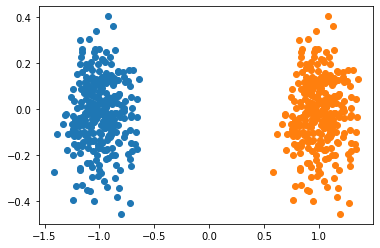

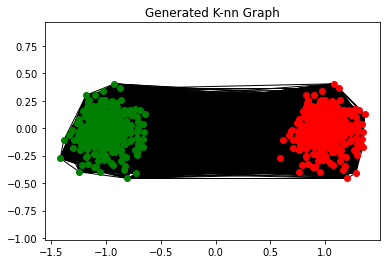

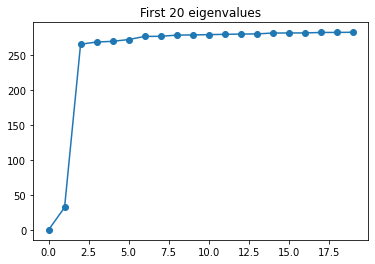

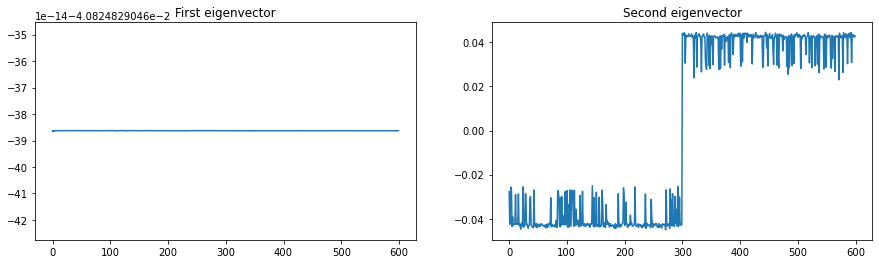

- Using thresholding method: 


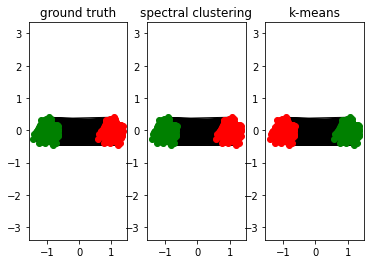

    The clustering score =  1.0

- Using built-in K-means: 


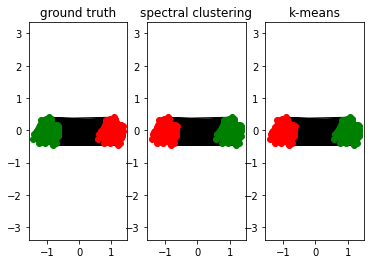

    The clustering score =  1.0


In [13]:
# Generate data in blobs 
num_classes = 2

X, Y = blobs(num_samples=600)
print()
print('                      Blobs Data')
plot_clusters(X, Y)
plt.show()

# k = 350 higher than the number of samples per cluster to ensure connectivity 
W = build_similarity_graph(X, k=350)
L = build_laplacian(W)

plot_edges_and_points(X, Y, W, title='Generated K-nn Graph')
plt.show()

#################################
# Perform spectral clustering 
#################################

eigenvalues, eigenvectors = scipy.linalg.eig(L)
idx = eigenvalues.argsort()  
eigenvalues = eigenvalues[idx].real
U = eigenvectors[:,idx].real
E = np.diag(eigenvalues)

plt.plot(eigenvalues[:20] ,marker = 'o')
plt.title("First 20 eigenvalues")
plt.show()

fig, ax = plt.subplots(1,2 , figsize=(15,4))
ax[0].plot(U[:,0])
ax[0].set_title('First eigenvector')
ax[1].plot(U[:,1])
ax[1].set_title('Second eigenvector')
plt.show()

chosen_eig_indices = [1]
U = U[:, chosen_eig_indices]

print('- Using thresholding method: ')
thresh = 0
Y_rec = (U>thresh).astype(int)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
print('    The clustering score = ' , np.round(skm.adjusted_rand_score(Y.reshape(600,), Y_rec.reshape(600,)),3))
print()

print('- Using built-in K-means: ')
Y_rec = KMeans(num_classes).fit_predict(U)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))  
print('    The clustering score = ' , np.round(skm.adjusted_rand_score(Y, Y_rec),3))

**Answer:**

> - In this question, our goal is to cluster two blobs. We chose to have a connected graph. Thus, we took a value of $k = 350~$ which is larger than the number of samples in each cluster, as previously discussed, to generate a $k-nn$ graph. Accordingly, the zero eigenvalue has a multiplicity of $1$ and its corresponding eigenvector is a constant vector. This result can be noticed from the plot of the first eigenvector. Since this vector is constant, choosing this vector for clustering will not add any information. Also, since we have two clusters, using the Rayleigh-Ritz theorem, **the second eigenvector** of the Laplacian matrix will be the convenient vector for clustering. The figure above shows the second eigenvector. This vector has the form of a step function, one part of its values are positive and the other part is negative. To calculate the clustering assignments, it is possible to **threshold the vector to 0**. Thus, the negative terms of the vector will be grouped in one cluster and the positive terms in another. A binary vector is then constructed which corresponds to the number of clusters. Finally, we obtained a very high performance of clustering with a score equal to $1.0$.
<br><br>
> - After that, running the k-means method, we can notice **no difference in results**. Both methods are able to separate the clusters. However, the k-means method is better because if we choose another threshold value, we may encounter poor clustering which is not the case with the k-means method because the threshold is implicit.

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.


                      Blobs Data


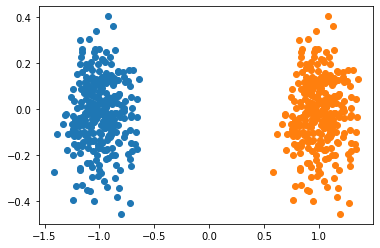

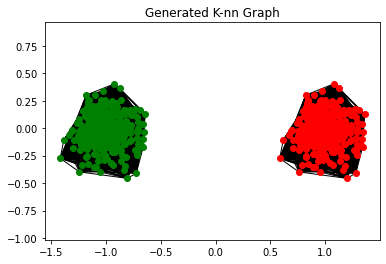

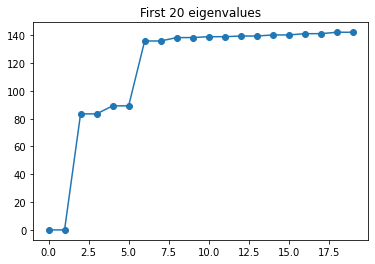

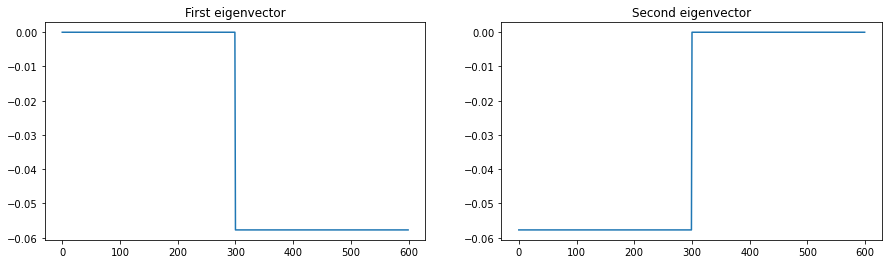

  Spectral clustering results, comparing to KMeans:


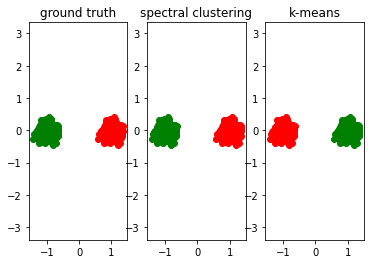

  The clustering score =  1.0


In [14]:
# Generate data in blobs 
num_classes = 2
X, Y = blobs(num_samples=600)

print()
print('                      Blobs Data')
plot_clusters(X, Y)
plt.show()

# k = 150 less than the number of samples per cluster to ensure separation of the two components
W = build_similarity_graph(X, k=150)
L = build_laplacian(W)

plot_edges_and_points(X, Y, W, title='Generated K-nn Graph')
plt.show()

#################################
# Perform spectral clustering 
#################################

eigenvalues, eigenvectors = scipy.linalg.eig(L)
idx = eigenvalues.argsort()  
eigenvalues = eigenvalues[idx].real
U = eigenvectors[:,idx].real
E = np.diag(eigenvalues)

plt.plot(eigenvalues[:20] ,marker = 'o')
plt.title("First 20 eigenvalues")
plt.show()

fig, ax = plt.subplots(1,2 , figsize=(15,4))
ax[0].plot(U[:,0])
ax[0].set_title('First eigenvector')
ax[1].plot(U[:,1])
ax[1].set_title('Second eigenvector')
plt.show()

chosen_eig_indices = [1]
U = U[:, chosen_eig_indices]

Y_rec = KMeans(num_classes).fit_predict(U)

print('  Spectral clustering results, comparing to KMeans:')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))  
print('  The clustering score = ' , np.round(skm.adjusted_rand_score(Y.reshape(600,), Y_rec.reshape(600,)),3))

**Answer:** 

> To build a disconnected graph, we chose $k = 150~$ which is less than the number of samples in each cluster. In this case, the first eigenvector is no longer a constant vector. This result is noticeable from the graph of the first eigenvector. Thus, this vector can be used for clustering. By also plotting the second eigenvector which corresponds to a very small value of the eigenvalue. We can see that this vector can also be used for clustering. In fact, these two vectors have the same shape as a step function but in a reversed direction. To build the clusters, I chose **the second eigenvector** because it gives the same clusters as the ground truth. After applying the k-means, we obtained very high performance with a clustering score equal to $1.0$. 

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

- With variance_blobs =  0.15 and k = 100
  The clustering score =  1.0
  Spectral clustering results, comparing to KMeans:


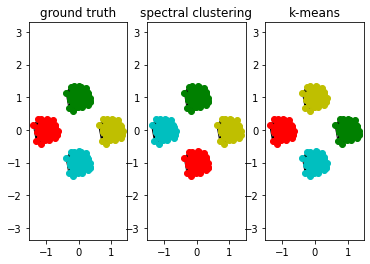


- With variance_blobs =  0.3  and k = 100
  The clustering score =  0.457
  Spectral clustering results, comparing to KMeans:


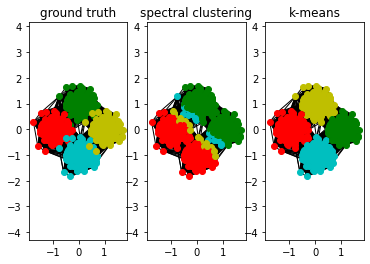


- With variance_blobs =  0.3  and k = 5
  The clustering score =  0.947
  Spectral clustering results, comparing to KMeans:


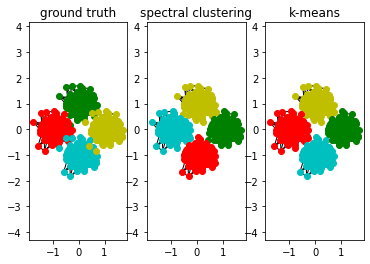


- With variance_blobs =  0.5  and k = 5
  The clustering score =  0.357
  Spectral clustering results, comparing to KMeans:


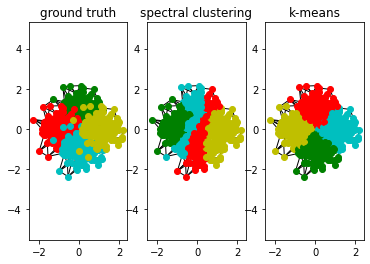

In [15]:
print('- With variance_blobs = ', 0.15 , 'and k = 100')

X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
W = build_similarity_graph(X, k=100)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=4)
print('  The clustering score = ' , np.round(skm.adjusted_rand_score(Y, Y_rec),3))
print('  Spectral clustering results, comparing to KMeans:')
plot_clustering_result(X, Y, L, Y_rec, KMeans(4).fit_predict(X))
plt.show()
print()

#####################################################
#####################################################

print('- With variance_blobs = ', 0.3, ' and k = 100')

X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.3)
W = build_similarity_graph(X, k=100)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=4)
print('  The clustering score = ' , np.round(skm.adjusted_rand_score(Y, Y_rec),3))
print('  Spectral clustering results, comparing to KMeans:')
plot_clustering_result(X, Y, L, Y_rec, KMeans(4).fit_predict(X))
plt.show()
print()

#####################################################
#####################################################
                            
print('- With variance_blobs = ', 0.3, ' and k = 5')

X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.3)
W = build_similarity_graph(X, k=5)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=4)
print('  The clustering score = ' , np.round(skm.adjusted_rand_score(Y, Y_rec),3))
print('  Spectral clustering results, comparing to KMeans:')
plot_clustering_result(X, Y, L, Y_rec, KMeans(4).fit_predict(X))
plt.show()
print()

#####################################################
#####################################################
           
print('- With variance_blobs = ', 0.5, ' and k = 5')
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.5)
W = build_similarity_graph(X, k=5)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=4)
print('  The clustering score = ' , np.round(skm.adjusted_rand_score(Y, Y_rec),3))
print('  Spectral clustering results, comparing to KMeans:')
plot_clustering_result(X, Y, L, Y_rec, KMeans(4).fit_predict(X))
plt.show()                                                

**Answer:** 

> - **The strategy:** <br>
> To make the algorithm automatically choose the eigenvectors for clustering, we proceeded as follows. First, we eliminated the first eigenvector because it may correspond to the vector describing the connected graph. Next, we looked for eigenvectors with very small eigenvalues. The chosen number will be restricted to eigenvectors having a sum of normalized eigenvalues lower than a threshold value which is in this case equal to $10^{-5}$. This value is selected after several trials in order to find the best value of the threshold. The selected eigenvectors are then used to form a new matrix. This matrix is used for clustering by applying k-means on the selected eigenvectors.
<br><br>
> - In this question, we tried the automatic clustering by increasing the variance of the blobs and varying the number $k$ of the $k-nn$ graph searching for the optimal value. For small value of variance, we fixed $k = 100~$ to ensure the connectivity of the graph. We notice that using this method, we obtained a very good clustering, with a score very close to $1.0$. When the variance increases to $0.3$, the blobs are less separated. We choosed in this case a small value of $k$ because the blobs now are overlapping and we dont neeed a larger $k$ to ganrantee the connectivity of the graph. In fact, by choosing $k = 100$, the method gives poor clustering results with a score around $0.45$. Whereas by reducing the value of $k$, the clustering performances increase. 
<br><br>
> For higher variance values, the eigenvalue plot will be smoother without showing jumps in values, making it more difficult to choose eigenvectors. This is why, this method failed in this case to select the appropriate number of eigenvectors for clustering as it only gives a score of $0.357$ and the predicted clusters are not well separated and do not preserve the correct shape of blobs. On the other hand, k-means gave correct clustering because this method focuses on the compactness of the blobs and not on the connectivity of the graph.

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

**Answer:** 

> k-means algorithm partition the dataset into k clusters where k is a defined parameter. Threshold based clustering is another method which generates the clusters based on a threshold value. 
<br><br>
> - When we built clusters assignment, we chose the k-means method. As explained earlier, k-means is better because by choosing an erroneous threshold value for the threshold method, we can get a poor clustering. But with k-means, this is not possible because clustering is done **automatically**.
<br><br>
> - Thresholding is easy to use for simple cases of datasets when we have information about the clustering vector. This is why we chose the k-means method because it is more **general** and can also be used for **multidimensional clustering vectors**. 

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

- With k = 20:


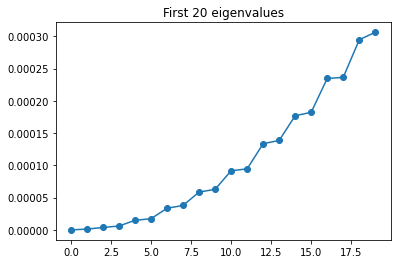

Chosen Eigenvectors are:


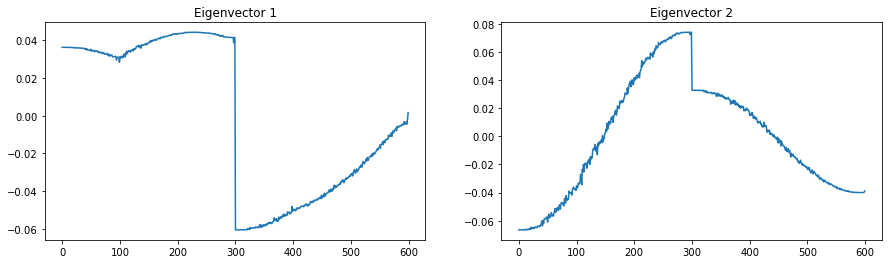

  The clustering score =  0.993
  Spectral clustering results, comparing to KMeans:


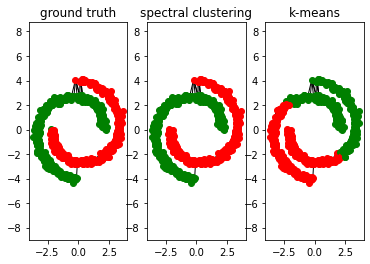


- With k = 60:


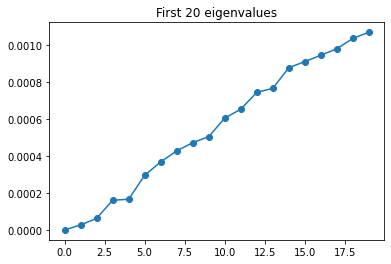

Chosen Eigenvectors are:


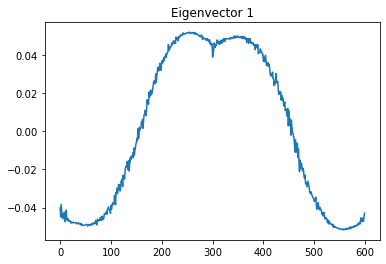

  The clustering score =  -0.0
  Spectral clustering results, comparing to KMeans:


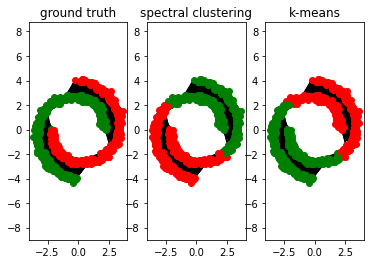

In [16]:
# Generate two moons data
num_classes = 2
X, Y = two_moons(num_samples=600)

# Less connected grah 
print('- With k = 20:')

W = build_similarity_graph(X, k=20)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes, show = True)
print('  The clustering score = ' , np.round(skm.adjusted_rand_score(Y, Y_rec),3))
print('  Spectral clustering results, comparing to KMeans:')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
plt.show()
print()

#####################################################
#####################################################

# More connected graph 
print('- With k = 60:')

W = build_similarity_graph(X, k=60)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes , show = True)
print('  The clustering score = ' , np.round(skm.adjusted_rand_score(Y, Y_rec),3))
print('  Spectral clustering results, comparing to KMeans:')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
plt.show()

**Answer:** 

> From the previous results, we can say that the graph with $k = 20$ is less connected than the graph with $k = 60$. In the first case, the spectral clustering works very well, while the k-means algorithm fails. Indeed, k-means, as a data clustering algorithm, is ideal for discovering globular clusters where all members of each cluster are very close to each other. This method is based only on Euclidean distances between points and centroids and does not consider the shape and the form of the data. Using the spectral clustering method, we achieve very good performance with $k=20$. In fact, spectral clustering is used to group data that are connected but not necessarily compact or grouped within convex boundaries. The two moons example is a case where the data should not be grouped on the basis of groups but on the basis of interconnected nodes that may be far apart in terms of Euclidean distance. 
<br><br>
> In the second case, with $k = 60$, we can see that both algorithms give similar results. Actually, the spectral clustering groups the points that are connected or immediately close to each other. Since most of the points are connected due to the high connectivity of the graph, the algorithm will combine them together, hence the resulting compact shape formed with this algorithm. This result can also be explained from the eigenvalue plot where the curve becomes smoother and thus selecting the appropriate eigenvectors will become a difficult task for clustering.

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

- With k = 50
   Using the normal Laplacian:
      The clustering score =  1.0


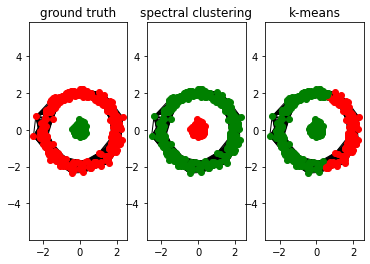

   Using the random-walk regularized Laplacian:
      The clustering score =  1.0


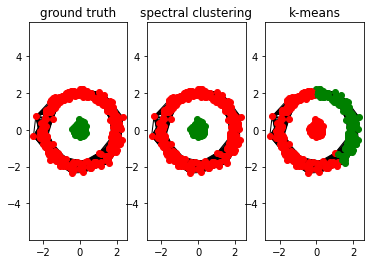

- With k = 100
   Using the normal Laplacian:
      The clustering score =  0.413


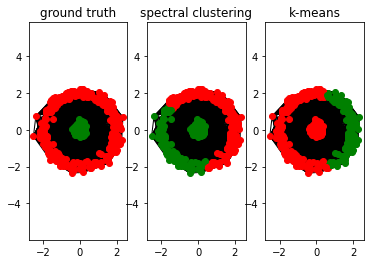

   Using the random-walk regularized Laplacian:
      The clustering score =  1.0


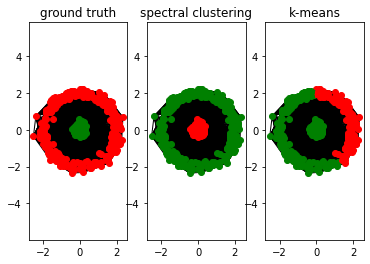

- With k = 200
   Using the normal Laplacian:
      The clustering score =  0.229


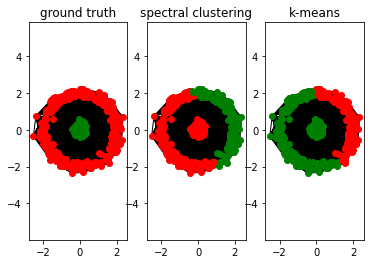

   Using the random-walk regularized Laplacian:
      The clustering score =  0.266


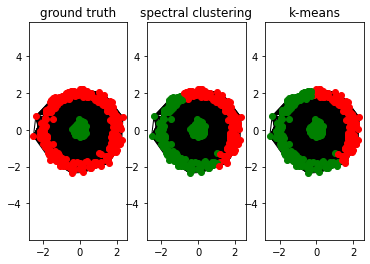

In [25]:
# Generate point and circle data
num_classes = 2
X, Y = point_and_circle(num_samples=600)

# List of k values 
k_list = [50,100,200]

for k in k_list :
    print('- With k =',k)
    
    print('   Using the normal Laplacian:')
    W = build_similarity_graph(X, k=k)
    L = build_laplacian(W)
    Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)
    print('      The clustering score = ' , np.round(skm.adjusted_rand_score(Y, Y_rec),3))
    plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
    plt.show()
    
    #####################################################
    #####################################################

    print('   Using the random-walk regularized Laplacian:')
    L = build_laplacian(W,laplacian_normalization='rw')
    Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)
    print('      The clustering score = ' , np.round(skm.adjusted_rand_score(Y, Y_rec),3))
    plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
    plt.show()

**Answer:** 

> In this question, we will increase the value of $k$ of the graph in order to keep more edges and connected nodes in the graph.
<br><br>
> - For the value $k = 50$, we can notice that the clustering using the normal Laplacian and the random walk regularized Laplacian give a perfect clustering, both methods are able to separate the circle from the blob cluster.
<br><br>
> - For the value $k = 100$, only the spectral clustering using the random walk regularized Laplacian is able to separate the two clusters. In fact, when we use the random walk regularized Laplacian, we optimize the NCut problem. whereas, when we use the normal Laplacian, we optimize the RatioCut problem. For NCut, we want to maximize the volume of clusters, which depends on the weights of the edges. In contrast, for the RatioCut problem, we want to maximize the number of vertices in the clusters. This number is not necessarily related to the intra-cluster similarity. That is why, in this case, the random walk regularized Laplacian is more effective in separating the blob from the circle since NCut algorithm is more robust to wrong connections as it is based on similarities within a cluster. 
<br><br>
> - By further increasing the value of $k$ to $200$, we found that both methods fail to cluster the classes. However, using the random walk regularized Laplacian, clustering results still outperform the normal Laplacian with a score of around $0.26$.

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

- KNN graph case: 


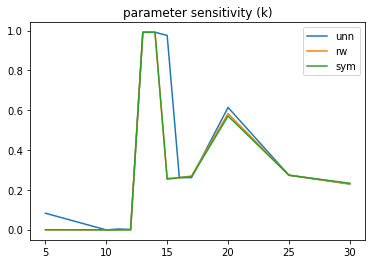

- Epsilon graph case: 


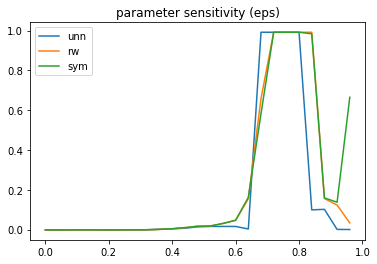

In [18]:
parameter_sensitivity()

**Answer:** 

> We generated a dataset of two moons with $500$ samples. We used the automatic clustering method to calculate the clustering assignments.
<br><br>
> - In a first part, we studied the sensitivity of clustering to the parameter $k$. We tried these values: $\{5,10,11,12,13,14,15,16,17,20,25,30\}$. We found that depending on the value chosen, the score can be low or high. Moreover, among the chosen values, $\{13, 14 ~\text{and,}~ 15\} $ give a very good clustering when using the normal Laplacian and $\{ 13 ~\text{and}~ 14 \}$ when using the normalized symmetric and random walk Laplacian matrices. In addition, we can notice that the spectral clustering is not stable when changing the values of $k$. Actually, the previous curves are fluctuating when we vary this value, it increases to reach peak values then decreases showing a poor performance for the highest values of $k$. 
<br><br>
> - In a second part, we studied the sensitivity of clustering to the parameter $eps$. We tried these values: $\{0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4, 0.44, 0.48, 0.52, 0.56, 0.6, 0.64, 0.68, 0.72, 0.76, 0.8, 0.8. , 0.88, 0.92, 0.96 \}$. Only values between $[0.6, 0.9]$ give perfect results, all the other values give very poor scores. We can also notice that small threshold values are not practical for spectral clustering. Furthermore, we can state that the spectral clustering is stable by varying $eps$ since the curves do not show many fluctuations. 
<br><br>
> $\Longrightarrow$ We can say that the behavior of clustering for both parameters is close when modifying the Laplacian matrix.

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

**Answer:** 

> When we did not have access to "True" labels, we could use the **Modularity** metric. In fact, modularity is a measure of the structure of a graph, measuring the density of connections within a module or a community even if no labels are available. This metric is based on both inter-cluster similarity and intra-cluster similarity, not just intra-cluster similarity. Thus, graph modularity can be a good metric to evaluate clustering results. It is defined as the fraction of the edges that fall within the given groups minus the expected fraction if edges were distributed at random.
<br><br>
> The modularity metric is computed as follows : 
> $$Q = \frac{1}{v} \sum_{i,j~ \in~ W} \, \big(W_{ij}-\frac{d_i d_j}{v} \big) ~ \delta(C(i), C(j))$$
> Where: 
>  - $d_i$ is the degree of node $i$. 
>  - $v$ is total number of degrees.
>  - $C(i)$ is the class of node $i$. 

In [19]:
def modularity(W, y):
    Q = 0
    v = np.sum(W)
    n = W.shape[0]
    
    for i in range(n):
        for j in range(n):
            if y[i]==y[j]:
                di = np.sum(W[i,:])
                dj = np.sum(W[j,:])
                Q += W[i,j] - di*dj/v
    Q /= v
    return Q

- Point and circle case:
  Spectral clustering results, comparing to KMeans:


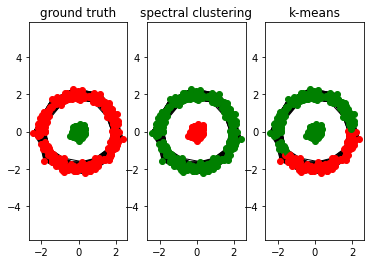

  Modularity score using Spectral Clustering : 0.482
  Modularity score using K-means Clustering : 0.27

- Two-moons case:
  Spectral clustering results, comparing to KMeans:


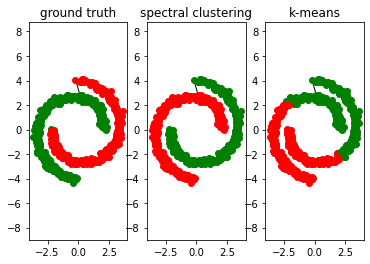

  Modularity score using Spectral Clustering : 0.5
  Modularity score using K-means Clustering : 0.487


In [20]:
print('- Point and circle case:')

# Generate Point and circle data
num_classes = 2
X, Y = point_and_circle(num_samples=600)

#################################
# Perform spectral clustering 
#################################

W = build_similarity_graph(X, k=50)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)

print('  Spectral clustering results, comparing to KMeans:')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

score_cs = modularity(W, Y_rec)
score_km = modularity(W, KMeans(num_classes).fit_predict(X))

print('  Modularity score using Spectral Clustering :',np.round(score_cs,3))
print('  Modularity score using K-means Clustering :',np.round(score_km,3))

##################################################################
##################################################################
print()
print('- Two-moons case:')

# Generate two-moons data
num_classes = 2
X, Y = two_moons(num_samples=600)

#################################
# Perform spectral clustering 
#################################

W = build_similarity_graph(X, k=15)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)

print('  Spectral clustering results, comparing to KMeans:')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

score_cs = modularity(W, Y_rec)
score_km = modularity(W, KMeans(num_classes).fit_predict(X))

print('  Modularity score using Spectral Clustering :',np.round(score_cs,3))
print('  Modularity score using K-means Clustering :',np.round(score_km,3))

**Interpretation:** 

> It is clear that spectral clustering performs very well compared to k-means. In addition, we found that the modularity score using spectral clustering is higher than that of k-means clustering, which confirms the hypothesis discussed earlier about how we should rely on both inter-cluster similarity and intra-cluster similarity.

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

Best segmentation results:
 - four_elements picture:


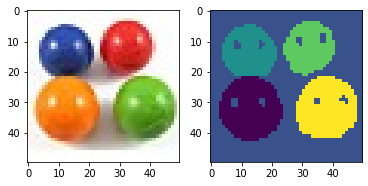

 - fruit_salad picture:


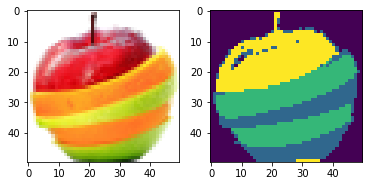

In [21]:
print('Best segmentation results:')
print(' - four_elements picture:')
image_segmentation(input_img='four_elements.bmp' , k=15 , laplacian_normalization='rw')

print(' - fruit_salad picture:')
image_segmentation(input_img='fruit_salad.bmp' , k=90 , laplacian_normalization='rw' ,  num_classes=4 )

Failure mode:
 - four_elements picture:


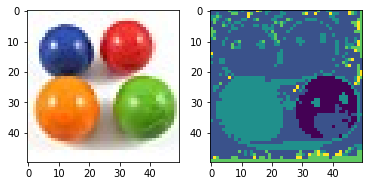

 - fruit_salad picture:


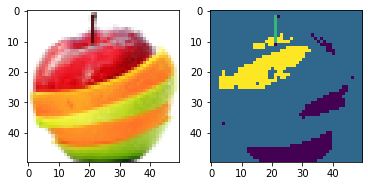

In [22]:
print('Failure mode:')
print(' - four_elements picture:')
image_segmentation(input_img='four_elements.bmp' , k=3 , laplacian_normalization='rw')

print(' - fruit_salad picture:')
image_segmentation(input_img='fruit_salad.bmp' , k= 3 , laplacian_normalization='rw' ,  num_classes=4)

**Answer:** 

> - In this question, we started by importing the image. After that, we standardized its values. Next, we constructed the graph using the random walk normalization for the Laplacian matrix and the $k-nn$ graph with a fixed value $k$ chosen to have the best clustering result. We notice that even a small change in the choice of $k$, will completely change the segmentation performance of the algorithm.
<br><br>
> - In case of failure, changing $k$ by any other value different from the optimal value will give an erroneous result.

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

**Answer:** 

> Our goal is to solve the eigenvalue problem and reduce the computational time and memory allocation. That is, we need a strategy to reduce the size of the image, in other words, reduce the size of the constructed graph.
<br><br>
> - My first idea is to start by downsampling the image before clustering it. Once we have a segmented version of the subsampled image, we can upsample it so that the segmented image matches the original one in size. In addition, to smooth the segmentation, we can add image filtering or morphological methods such as Gaussian filtering or the opening operator.
<br><br>
> - Another idea is to generate super-pixels using the SLIC method as an example. In fact, the super-pixels are groups of pixels with similar characteristics. Then, each group of pixels is used as a node in the new graph. Finally, we apply clustering on this new graph. 

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

- Original Image:


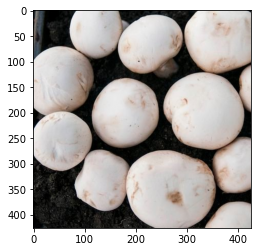

- Down Sampled Image:


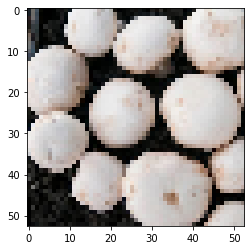

Clustering ...
Clustering is finished

- Up Sampled Image:


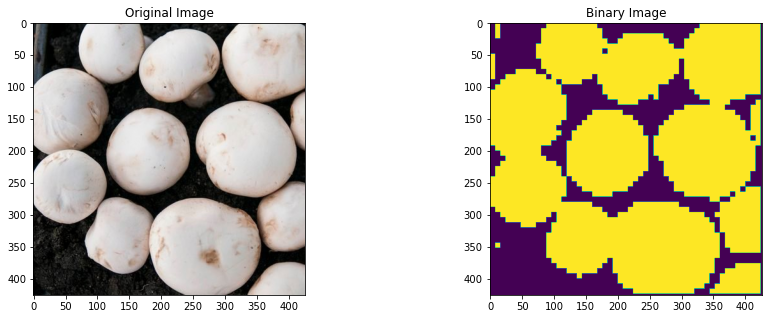

- Post-processed Image:


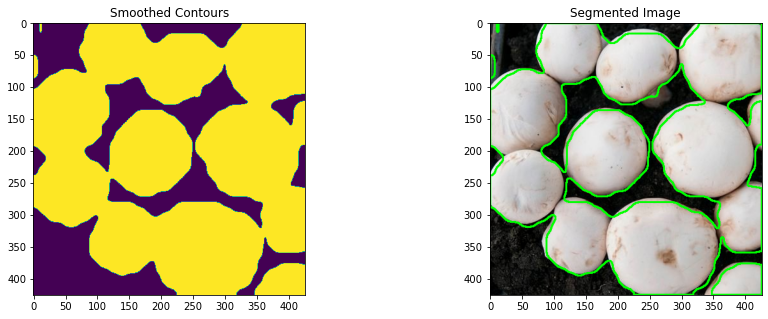

In [23]:
# Chosen larger image: Mushroom image
filename = 'new.bmp'
image = io.imread(filename)[:,:,:3]
X = (image - np.min(image)) / (np.max(image) - np.min(image))
[m, n, l] = X.shape
num_classes = 2

print('- Original Image:')
plt.imshow(X)
plt.show()

# Down sampling
f = 8
img2 = np.zeros((m//f, n//f,l))

for k in range(l):
    X_  = X[:,:,k]
    for i in range(0, m, f):
        for j in range(0, n, f):
            try:
                img2[i//f,j//f,k] = X_[i][j]
            except IndexError:
                pass

# Show down sampled image
print('- Down Sampled Image:')
plt.imshow(img2)
plt.show()

# Clustering 
print('Clustering ...')
im_side1 , im_side2 = img2.shape[0] , img2.shape[1] 
Xr = img2.reshape(im_side1 * im_side2 , 3)
W = build_similarity_graph(Xr, var=1.0, k=22)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, None, num_classes=num_classes)
Y_rec = Y_rec.reshape(im_side1, im_side2)
print('Clustering is finished')
print()

# Up sampling
img3 = np.zeros((m, n))

for i in range(0, m-f, f):
    for j in range(0, n-f, f):      
        img3[i, j] = Y_rec[i//f][j//f]

for i in range(1, m-(f-1), f):
    for j in range(0, n-(f-1)):
        img3[i:i+(f-1), j] = img3[i-1, j]

for i in range(0, m-1):
    for j in range(1, n-1, f):
        img3[i, j:j+(f-1)] = img3[i, j-1]
        
# Show up sampled image
print('- Up Sampled Image:')
fig , ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(X)
ax[0].set_title('Original Image')
ax[1].imshow(img3)
ax[1].set_title('Binary Image')
plt.show()

# Smooth the contours 
img4 = cv2.GaussianBlur(img3.astype(np.uint8),(35,35),0)
contours,_ = cv2.findContours(img4, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img5 = cv2.drawContours(image.astype(np.uint8) , contours, -1, (0, 255, 0), 2)

print('- Post-processed Image:')
fig , ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(img4)
ax[0].set_title('Smoothed Contours')
ax[1].imshow(img5)
ax[1].set_title('Segmented Image')
plt.show()

**Answer:** 

> In this question, I started by downsampling the image with a factor of $8$. Then, I performed the spectral clustering on this new image. The result is then up-sampled. A Gaussian filter is also applied to smooth the boundaries of segmented regions. Finally, we obtained very promising results.